In [329]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Embedding, SimpleRNN, Input, Reshape
from tensorflow.keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle

In [278]:
def convert_to_list(string):
    return [float(i) if i != '' else 0 for i in string.split(', ')]

def process_dataset(df):
    columns = ['time', 'mag', 'flux']
    for i in columns:
        df[i] = df[i].apply(lambda x: x[1:-1])
        df = df[~df[i].isnull()]
        df[i] = df[i].apply(convert_to_list)
    return df

def interpolate_(data, num = 261):
    x = data['time']
    y = data['mag']
    new_mag = []
    new_time = []
    for i in range(len(data)):
        t = data.iloc[i]['time']
        x = data.iloc[i]['mag']
        newt = np.linspace(min(t), max(t), num, endpoint=True)
        f = interp1d(t, x)
        newx = f(newt)
        new_mag.append(newx)
        new_time.append(newt)
    df_t = pd.DataFrame({"intrpol_time":[i for i in new_t], "intrpol_mag": [i for i in new_m]})
    return df_t

def scale(data):
    new_mag = []
    for i in range(len(data)):
        mean_ = np.mean(data.iloc[i]['intrpol_mag'])
        std_ = np.std(data.iloc[i]['intrpol_mag'])
        scaled_v = (data.iloc[i]['intrpol_mag'] - mean_) / std_
        new_mag.append(list(scaled_v))
    return [i for i in new_mag]

def onehot_encoder(y):
    k = len(np.unique(y))
    return np.eye(k)[y]

In [279]:
df =  pd.read_csv(r'D:\Data\Mini Dataset\final_df_g.csv', index_col = 0)
df = process_dataset(df)
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.head(2)

,source_id,band,time,mag,flux,label
0,1051896903074455936,G,"[1709.0473075002526, 1709.12129661769, 1746.93...","[14.779410003765635, 14.61257323866902, 14.388...","[23077.180413664224, 26910.232583122888, 33064...",CEP
1,1113929871645836672,G,"[1705.0618115528753, 1742.1944699213775, 1781....","[11.034948789103318, 10.976913805916949, 11.27...","[726051.1726333069, 765916.145348983, 580536.1...",CEP


In [280]:
df = pd.concat([df, interpolate_(df[['time','mag']])], axis = 1)

In [281]:
df['scaled_mag'] = scale(df)

In [320]:
X = df['scaled_mag']
y = df[['label']]

In [321]:
le = LabelEncoder().fit(y['label'])
y = le.transform(y['label'])
y = onehot_encoder(y)

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [288]:
length = [len(i) for i in X]
print(max(length))

261


In [ ]:
max_words = 261
postpad_X = sequence.pad_sequences(X_train, padding='post', maxlen = max_words, dtype='float')
postpad_X = np.expand_dims(postpad_X,axis=2)

In [289]:
X_train = np.array([i for i in X_train])
X_train = np.expand_dims(X_train, axis = 2)

X_test = np.array([i for i in X_test])
X_test = np.expand_dims(X_test, axis = 2)

In [236]:
input_ = Input(shape = (261,1))
rnn1 = SimpleRNN(64, return_sequences=False)(input_)
output = Dense(4, activation='softmax')(rnn1)
model = Model(inputs=input_, outputs=output)
# summarize layers
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 261, 1)]          0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________
None


In [237]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [238]:
# Create callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min',restore_best_weights=True)
lr = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min', restore_best_weights=True)
callback = [checkpoint, early_stop, lr]

In [245]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=64, callbacks= callback)

Epoch 1/20
601/601 [==============================] - 159s 252ms/step - loss: 1.2901 - accuracy: 0.3642 - val_loss: 1.2190 - val_accuracy: 0.4229

Epoch 00001: val_loss improved from inf to 1.21899, saving model to best_model.h5
Epoch 2/20
601/601 [==============================] - 154s 256ms/step - loss: 1.2920 - accuracy: 0.3873 - val_loss: 1.3703 - val_accuracy: 0.2756

Epoch 00002: val_loss did not improve from 1.21899
Epoch 3/20
601/601 [==============================] - 154s 256ms/step - loss: 1.2102 - accuracy: 0.4153 - val_loss: 1.0971 - val_accuracy: 0.4866

Epoch 00003: val_loss improved from 1.21899 to 1.09706, saving model to best_model.h5
Epoch 4/20
601/601 [==============================] - 154s 256ms/step - loss: 1.2466 - accuracy: 0.4066 - val_loss: 1.2519 - val_accuracy: 0.3878

Epoch 00004: val_loss did not improve from 1.09706
Epoch 5/20
601/601 [==============================] - 152s 253ms/step - loss: 1.2351 - accuracy: 0.4070 - val_loss: 1.2494 - val_accuracy: 0.3

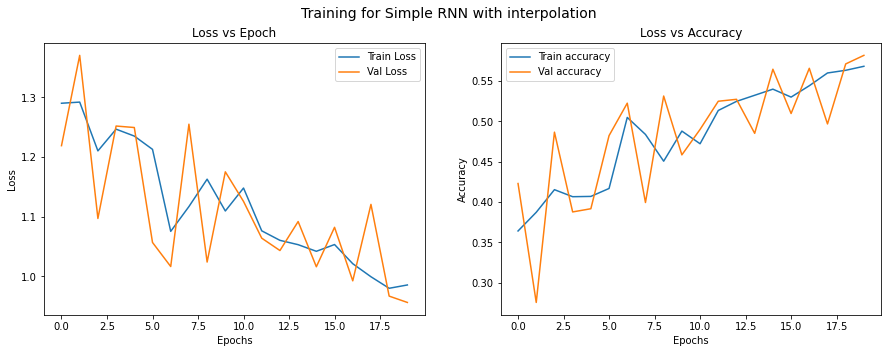

In [266]:
f,axs = plt.subplots(1,2, figsize=(15,5))
f.suptitle("Training for Simple RNN with interpolation", fontsize=14)

axs[0].plot(history.history['loss'], label="Train Loss")
axs[0].plot(history.history['val_loss'], label="Val Loss")
axs[0].legend()
axs[0].set_title("Loss vs Epoch")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

axs[1].plot(history.history['accuracy'], label="Train accuracy")
axs[1].plot(history.history['val_accuracy'], label="Val accuracy")
axs[1].legend()
axs[1].set_title("Loss vs Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
plt.show()

In [300]:
model.evaluate(X_test, y_test)

376/376 [==============================] - 28s 61ms/step - loss: 0.9442 - accuracy: 0.5892


[0.9442304372787476, 0.5891711711883545]

In [304]:
prediction = model.predict(X_train)
prediction = np.argmax(prediction, axis = 1)

In [326]:
print(classification_report(prediction, np.argmax(y_train, axis = 1), target_names = le.classes_))

              precision    recall  f1-score   support

         CEP       0.42      0.44      0.43     11528
         ECP       0.90      0.74      0.81     14649
         LPV       0.33      0.53      0.41      7546
          RR       0.67      0.56      0.61     14293

    accuracy                           0.58     48016
   macro avg       0.58      0.57      0.57     48016
weighted avg       0.63      0.58      0.60     48016



In [328]:
save_model(model, r"models\simpleRNN_Interpolation_Normalized.h5")
with open(r"histories\simpleRNN_Interpolation_Normalized.pkl", 'wb') as f:
    pickle.dump(history.history, f)

In [333]:
model = load_model(r"models\simpleRNN_Interpolation_Normalized.h5")
with open(r"histories\simpleRNN_Interpolation_Normalized.pkl", 'rb') as f:
    pickle.load(f)


## SimpleRNN with Conv1D filter = 1

In [335]:
input_ = Input(shape=(None, 1))
conv1d_ = Conv1D(filters = 1, kernel_size = 5, activation='relu', padding= "same")(input_)
rnn1_ = SimpleRNN(64, return_sequences=False)(conv1d_)
dense_ = Dense(4, activation='softmax')(rnn1_)

model = Model(inputs = input_, outputs = dense_)

In [336]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min',restore_best_weights=True)
lr = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min', restore_best_weights=True)
callback = [checkpoint, early_stop, lr]

In [337]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=64, callbacks= callback)

Epoch 1/20
601/601 [==============================] - 253s 355ms/step - loss: 1.3452 - accuracy: 0.3324 - val_loss: 1.3388 - val_accuracy: 0.3278

Epoch 00001: val_loss improved from inf to 1.33879, saving model to best_model.h5
Epoch 2/20
601/601 [==============================] - 213s 354ms/step - loss: 1.3643 - accuracy: 0.3040 - val_loss: 1.3572 - val_accuracy: 0.3172

Epoch 00002: val_loss did not improve from 1.33879
Epoch 3/20
601/601 [==============================] - 217s 360ms/step - loss: 1.3544 - accuracy: 0.3158 - val_loss: 1.3798 - val_accuracy: 0.2654

Epoch 00003: val_loss did not improve from 1.33879
Epoch 4/20
601/601 [==============================] - 212s 352ms/step - loss: 1.3832 - accuracy: 0.2758 - val_loss: 1.3644 - val_accuracy: 0.2936

Epoch 00004: val_loss did not improve from 1.33879
Epoch 5/20
601/601 [==============================] - 211s 352ms/step - loss: 1.3567 - accuracy: 0.3138 - val_loss: 1.3597 - val_accuracy: 0.3041

Epoch 00005: val_loss did not 

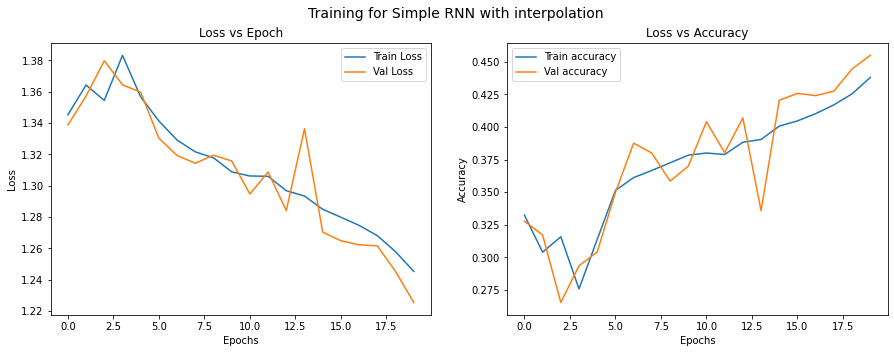

In [338]:
f,axs = plt.subplots(1,2, figsize=(15,5))
f.suptitle("Training for Simple RNN with interpolation", fontsize=14)

axs[0].plot(history.history['loss'], label="Train Loss")
axs[0].plot(history.history['val_loss'], label="Val Loss")
axs[0].legend()
axs[0].set_title("Loss vs Epoch")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

axs[1].plot(history.history['accuracy'], label="Train accuracy")
axs[1].plot(history.history['val_accuracy'], label="Val accuracy")
axs[1].legend()
axs[1].set_title("Loss vs Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
plt.show()

In [339]:
model.evaluate(X_test, y_test)

376/376 [==============================] - 19s 49ms/step - loss: 1.2288 - accuracy: 0.4580


[1.2287896871566772, 0.457975834608078]

In [344]:
X_ = np.array([i for i in X])
X_ = np.expand_dims(X_, axis = 2)

prediction = model.predict(X_)
prediction = np.argmax(prediction, axis = 1)

In [346]:
print(classification_report(prediction, np.argmax(y, axis = 1), target_names = le.classes_))

              precision    recall  f1-score   support

         CEP       0.39      0.41      0.40     14445
         ECP       0.43      0.48      0.45     13457
         LPV       0.64      0.44      0.52     22018
          RR       0.37      0.55      0.45     10101

    accuracy                           0.46     60021
   macro avg       0.46      0.47      0.45     60021
weighted avg       0.49      0.46      0.46     60021



In [347]:
save_model(model, r"models\simpleRNN_Interpolation_Normalized_With_Conv1D.h5")
with open(r"histories\simpleRNN_Interpolation_Normalized_With_Conv1D.pkl", 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
model = load_model(r"models\simpleRNN_Interpolation_Normalized_With_Conv1D.h5")
with open(r"histories\simpleRNN_Interpolation_Normalized_With_Conv1D.pkl", 'rb') as f:
    pickle.load(f)


## SimpleRNN with Conv1D filter = 5

In [351]:
input_ = Input(shape=(None, 1))
conv1d_ = Conv1D(filters = 5, kernel_size = 5, activation='relu', padding= "same")(input_)
rnn1_ = SimpleRNN(64, return_sequences=False)(conv1d_)
dense_ = Dense(4, activation='softmax')(rnn1_)

model = Model(inputs = input_, outputs = dense_)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min',restore_best_weights=True)
lr = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min', restore_best_weights=True)
callback = [checkpoint, early_stop, lr]

In [352]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 5)           30        
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 64)                4480      
Total params: 4,510
Trainable params: 4,510
Non-trainable params: 0
_________________________________________________________________
